<a href="https://www.kaggle.com/code/rishitjakharia/isruc-eda?scriptVersionId=214368494" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing

In [1]:
import os
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader

from scipy.signal import butter, filtfilt

# Initial Graphs for class imbalance

In [2]:
# event_count = 0

# for foldername, subfolders, filenames in os.walk('/kaggle/input/isruc-processed/dataset/Events'):
#     if foldername.split('/')[-1] == 'Events':
#         continue
#     event_count += len(filenames)
#     print(f"Event: '{foldername.split('/')[-1]}' has {len(filenames)} files.")


# for foldername, subfolders, filenames in os.walk('/kaggle/input/isruc-processed/dataset/Non_Events'):
#     if foldername.split('/')[-1] == 'Events':
#         continue
#     event_count += len(filenames)
#     print(f"Event: '{foldername.split('/')[-1]}' has {len(filenames)} files.")


# print(f"Total Event count: {event_count}")

Now, to maintain class balance when learning a sleep stage classifier and to have sufficient amount of non-event examples we shall sample the sum of all these.

Also, we are only looking at the cases where both Experts classify the event as a non-event.

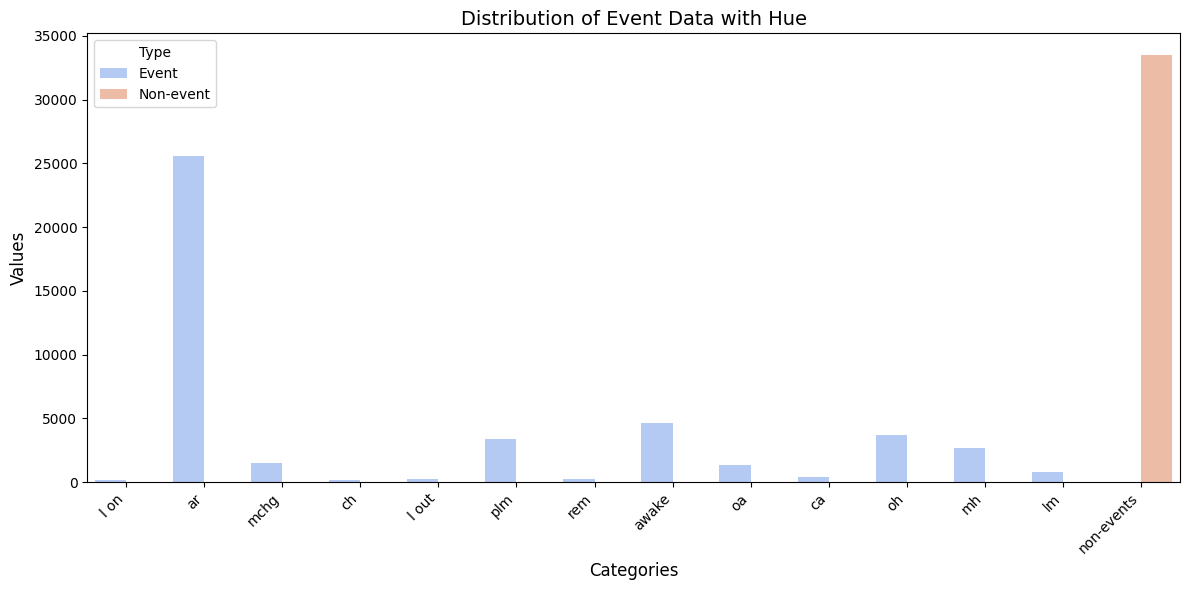

In [3]:
files = {
    'l on': 141,
    'ar': 25544,
    'mchg': 1530,
    'ch': 159,
    'l out': 218,
    'plm': 3402,
    'rem': 213,
    'awake': 4666,
    'oa': 1374,
    'ca': 362,
    'oh': 3652,
    'mh': 2707,
    'lm': 823,
    'non-events': 33531
}

# Prepare data for plotting
categories = list(files.keys())
values = list(files.values())

# Convert data to a DataFrame for seaborn
data = pd.DataFrame({
    'Category': categories,
    'Value': values
})

# Add a hue column for demonstration (e.g., splitting events into "Events" and "Non-events")
data['Type'] = ['Event' if cat != 'non-events' else 'Non-event' for cat in categories]

# Plotting with seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='Category', y='Value', hue='Type', palette='coolwarm')
plt.xlabel('Categories', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Distribution of Event Data with Hue', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

There seems to be severe class imbalance, looking at the relevant labels now

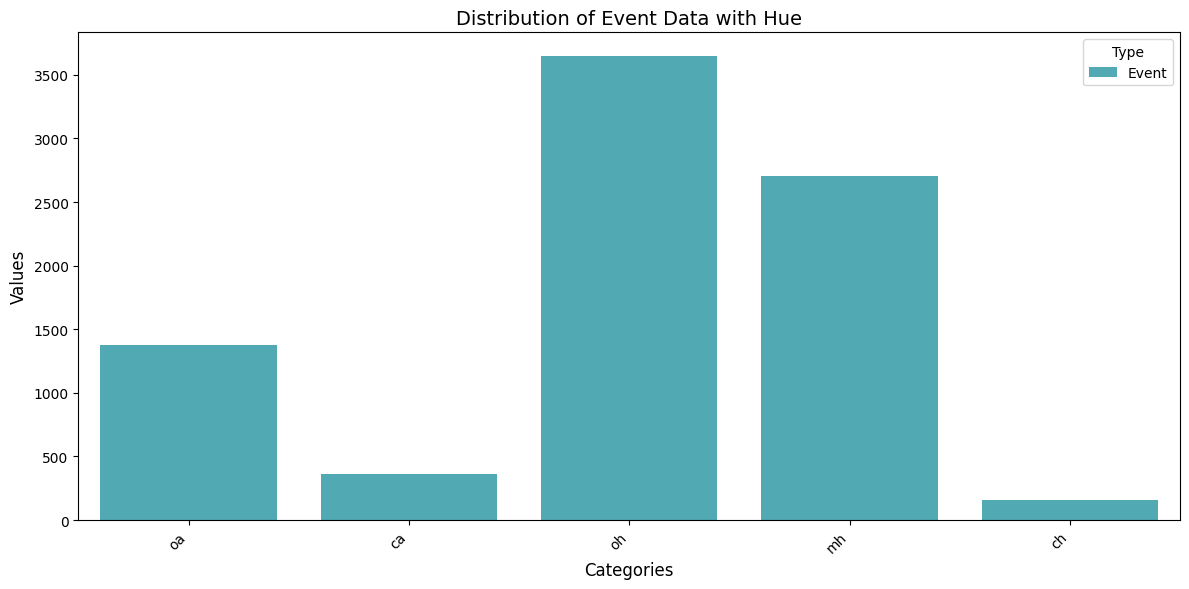

In [4]:
files = {
    'oa': 1374,
    'ca': 362,
    'oh': 3652,
    'mh': 2707,
    'ch': 159
}

# Prepare data for plotting
categories = list(files.keys())
values = list(files.values())

# Convert data to a DataFrame for seaborn
data = pd.DataFrame({
    'Category': categories,
    'Value': values
})

# Add a hue column for demonstration (e.g., splitting events into "Events" and "Non-events")
data['Type'] = ['Event' if cat != 'non-events' else 'Non-event' for cat in categories]

# Plotting with seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='Category', y='Value', hue='Type', palette='YlGnBu')
plt.xlabel('Categories', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Distribution of Event Data with Hue', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Clearly the class of ca is severely under represented

# Loading Data
----

## Sleep Stage Dataset

In [11]:
class Normalization(object):
    def __init__(self, method="z-score", axis=1, epsilon=1e-8):
        """
        Args:
            method (str): Normalization method ('z-score' or 'min-max').
            axis (int): Axis along which to normalize (0: samples, 1: channels).
            epsilon (float): Small constant to avoid division by zero.
        """
        self.method = method
        self.axis = axis
        self.epsilon = epsilon

    def __call__(self, signal):
        """
        Apply normalization to the signal.

        Args:
            signal (torch.Tensor): Signal tensor of shape (n_channels, n_samples).
        
        Returns:
            torch.Tensor: Normalized signal tensor of the same shape.
        """
        signal_np = signal.numpy() if isinstance(signal, torch.Tensor) else signal

        if self.method == "z-score":
            mean = np.mean(signal_np, axis=self.axis, keepdims=True)
            std = np.std(signal_np, axis=self.axis, keepdims=True) + self.epsilon
            normalized_signal = (signal_np - mean) / std
        elif self.method == "min-max":
            min_val = np.min(signal_np, axis=self.axis, keepdims=True)
            max_val = np.max(signal_np, axis=self.axis, keepdims=True) + self.epsilon
            normalized_signal = (signal_np - min_val) / (max_val - min_val)
        else:
            raise ValueError("Unsupported normalization method. Choose 'z-score' or 'min-max'.")

        return torch.tensor(normalized_signal, dtype=torch.float32)

In [6]:
class BandpassFilter(object):
    def __init__(self, lowcut, highcut, fs, order=4, padding_value=0):
        """
        Args:
            lowcut (float): Low frequency cutoff (Hz).
            highcut (float): High frequency cutoff (Hz).
            fs (float): Sampling frequency (Hz).
            order (int): Order of the filter.
            padding_value (float): Value to use for padding short signals.
        """
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.order = order
        self.padding_value = padding_value
        
        # Design the filter
        nyquist = 0.5*fs
        self.b, self.a = butter(self.order, [self.lowcut/nyquist, self.highcut/nyquist], btype='band')

    def __call__(self, signal):
        """
        Apply the bandpass filter to each channel in the signal.

        Args:
            signal (tensor): Signal tensor of shape (n_channels, n_samples).
        
        Returns:
            tensor: Filtered signal tensor of the same shape.
        """
        filtered_signal = []
        
        # Apply the filter to each channel
        for i in range(signal.shape[1]):  # Iterate over channels
            channel_signal = signal[:, i]
            
            # Pad the signal if it's too short
            if len(channel_signal) <= self.order:
                padding_length = self.order - len(channel_signal) + 1
                channel_signal = np.pad(channel_signal, (padding_length, padding_length), mode='constant', constant_values=self.padding_value)
            
            # Apply the filter to the padded signal
            filtered_signal.append(filtfilt(self.b, self.a, channel_signal))

        # Convert back to tensor
        return torch.tensor(filtered_signal, dtype=torch.float32)

In [7]:
class SleepStageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Root directory containing all folders and signal files.
            transform (callable, optional): Optional transform to apply to the signals.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data_info = self._prepare_file_list()

    def _prepare_file_list(self):
        """Scan the dataset directory and prepare a list of file paths and labels."""
        data_info = []
        for event_type in ['Events', 'Non_Events']:
            folder_path = os.path.join(self.root_dir, event_type)
            if os.path.isdir(folder_path):
                for subfolder_name in os.listdir(folder_path):
                    subfolder_path = os.path.join(folder_path, subfolder_name)
                    if os.path.isdir(subfolder_path):
                        for file_name in os.listdir(subfolder_path):
                            # Full file path
                            file_path = os.path.join(subfolder_path, file_name)
                            # Extraxt sleep stage label from filename
                            label = file_name.split('_')[3].replace('Stage', '')
                            
                            # Ignore errorneous labels
                            if label not in ['w', 'n1', 'n2', 'n3', 'r']:
                                continue
                            
                            data_info.append((file_path, label))
                            
        return data_info

    def __len__(self):
        return len(self.data_info)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get file path and label
        file_path, label = self.data_info[idx]

        # converting label to one-hot
        label_to_one_hot = {
            'w':  [1,0,0,0,0],
            'n1': [0,1,0,0,0],
            'n2': [0,0,1,0,0],
            'n3': [0,0,0,1,0],
            'r':  [0,0,0,0,1],
        }
        label = label_to_one_hot[label]

        possible_columns = [
        ['X6', 'X7', 'X8', 'SaO2'],
        ['X6', 'X7', 'X8', 'SpO2'],
        ['29', '30', '31', 'SaO2'],
        ['29', '30', '31', 'SpO2']
        ]
        
        # Load signal data from .npy file
        signal = pd.read_csv(file_path)

        for columns in possible_columns:
            if all(col in signal.columns for col in columns):
                signal = signal[columns]
                break

        signal = torch.tensor(signal.values, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            for transform in self.transform:
                signal = transform(signal)

        signal_np = signal.numpy().T
        x_values = range(signal_np.shape[0])  # This gives you an array from 0 to n_samples-1
        
        # Set up the plot
        plt.axis([0, 375, -5, 5])
        
        try:
            # Plot the second, third, and fourth channels (columns)
            plt.plot(x_values, signal_np[:, 0], label='Flow 1')  # First channel (X6 or 29)
            plt.plot(x_values, signal_np[:, 1], label='Abdominal Pressure 1')  # Second channel (X7 or 30)
            plt.plot(x_values, signal_np[:, 2], label='Abdominal Pressure 2')  # Third channel (X8 or 31)
            plt.plot(x_values, signal_np[:, 3], label='SpO2/SaO2')  # Fourth channel (SaO2 or SpO2)
            
            plt.legend()
            plt.xlabel('Time (Samples)')  # X-axis label
            plt.ylabel('Signal Amplitude')  # Y-axis label
            plt.show()
        
        except Exception as e:
            print(f"Error while plotting: {e}")
            # If there was an error in the try block, fall back to plotting the first three columns
            plt.plot(x_values, signal_np[:, 0], label='Flow 1')  # First channel (X6 or 29)
            plt.plot(x_values, signal_np[:, 1], label='Abdominal Pressure 1')  # Second channel (X7 or 30)
            plt.plot(x_values, signal_np[:, 2], label='Abdominal Pressure 2')  # Third channel (X8 or 31)
            plt.plot(x_values, signal_np[:, 3], label='SpO2/SaO2')  # Fourth channel (SaO2 or SpO2)
            plt.legend()
            plt.xlabel('Time (Samples)')
            plt.ylabel('Signal Amplitude')
            plt.show()
        
        return signal, label

/tmp/ipykernel_24/2219041251.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(filtered_signal, dtype=torch.float32)


(4, 1)


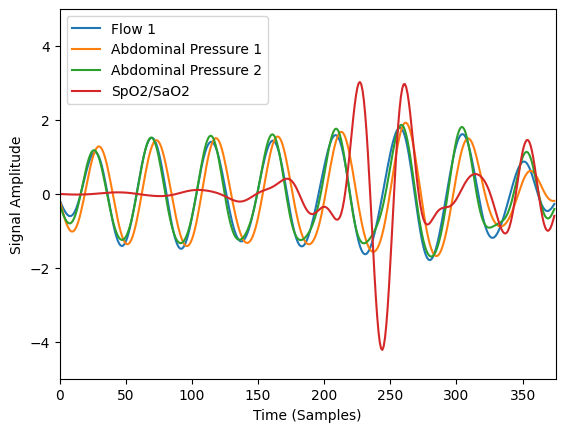

torch.Size([1, 4, 375])
tensor([[0, 0, 1, 0, 0]])
(4, 1)


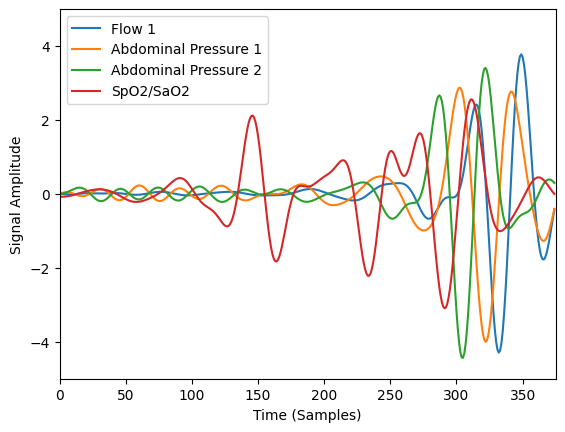

torch.Size([1, 4, 375])
tensor([[1, 0, 0, 0, 0]])
(4, 1)


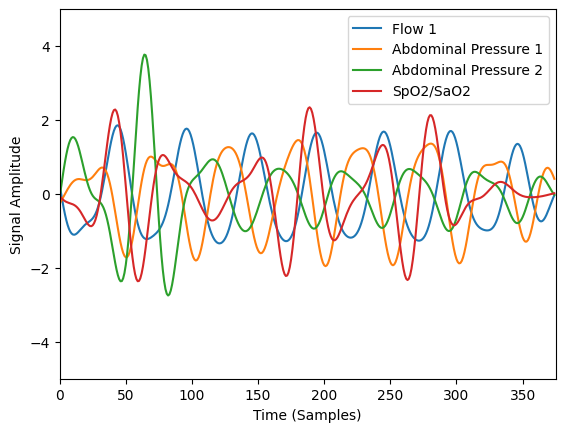

torch.Size([1, 4, 375])
tensor([[0, 0, 1, 0, 0]])
(4, 1)


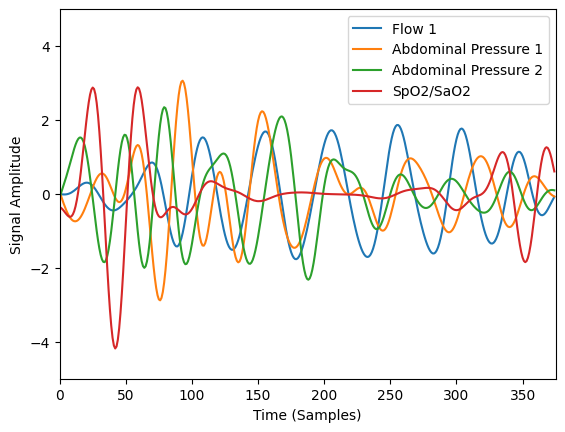

torch.Size([1, 4, 375])
tensor([[1, 0, 0, 0, 0]])
(4, 1)


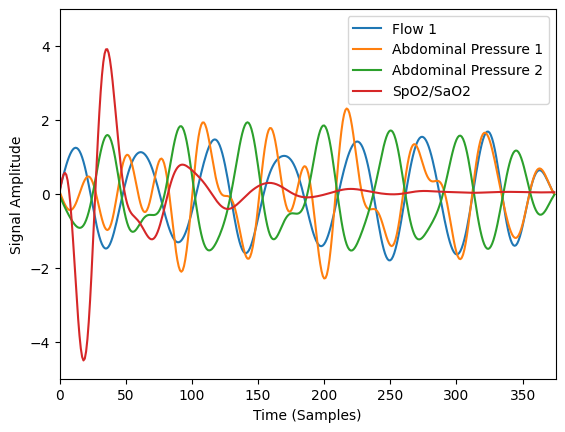

torch.Size([1, 4, 375])
tensor([[0, 0, 1, 0, 0]])
(4, 1)


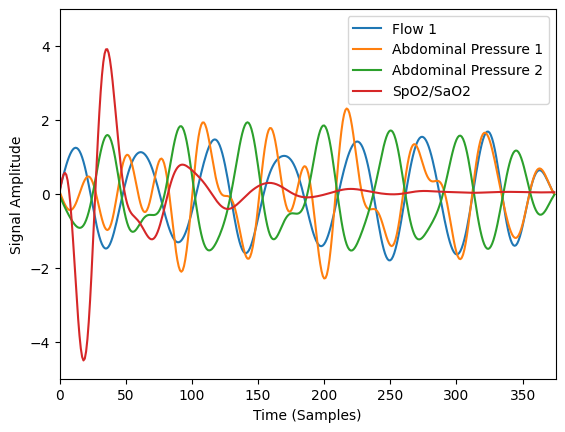

torch.Size([1, 4, 375])
tensor([[0, 0, 1, 0, 0]])


In [8]:
root_dir = '/kaggle/input/isruc-processed/dataset'

# Create an instance of the SleepStageDataset
transform = [BandpassFilter(lowcut=0.2, highcut=0.5, fs=12.5), Normalization(method="z-score", axis=1)]
# transform = [Normalization(method="z-score", axis=1), BandpassFilter(lowcut=0.2, highcut=0.8, fs=12.5)]

sleep_stage_dataset = SleepStageDataset(root_dir=root_dir, transform=transform)

# Wrap in a DataLoader for batch processing
sleep_stage_loader = DataLoader(sleep_stage_dataset, batch_size=1, shuffle=False)

# Iterate through the DataLoader
count = 5
for signals, labels in sleep_stage_loader:
    print(signals.shape)
    print(labels)
    if count == 0:
        break
    count -= 1

## Events classification dataset

In [12]:
class EventClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None, included_classes=None):
        """
        Args:
            root_dir (str): Root directory containing all folders and signal files.
            transform (callable, optional): Optional transform to apply to the signals.
            included_classes (list, optional): List of classes to include. If None, include all classes.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.included_classes = included_classes
        self.data_info = self._prepare_file_list()

    def _prepare_file_list(self):
        """Scan the dataset directory and prepare a list of file paths and labels."""
        data_info = []

        # Process Event files
        event_path = os.path.join(self.root_dir, 'Events')
        if os.path.isdir(event_path):
            for label_folder in os.listdir(event_path):
                if self.included_classes and label_folder not in self.included_classes:
                    continue

                label_path = os.path.join(event_path, label_folder)
                if os.path.isdir(label_path):
                    for file_name in os.listdir(label_path):
                        # Full file path
                        file_path = os.path.join(label_path, file_name)

                        # Append (file_path, label) tuple
                        data_info.append((file_path, label_folder))

        # Process Non Event files
        upper_limit_to_no_events = 3_000
        non_event_path = os.path.join(self.root_dir, 'Non_Events')
        if os.path.isdir(non_event_path):
            for subfolder_name in os.listdir(non_event_path):
                subfolder_path = os.path.join(non_event_path, subfolder_name)
                if os.path.isdir(subfolder_path):
                    for file_name in os.listdir(subfolder_path):
                        # Full file path
                        file_path = os.path.join(subfolder_path, file_name)

                        # Label for non-events is "no_event"
                        if not self.included_classes or 'no_event' in self.included_classes:
                            data_info.append((file_path, 'no_event'))

                        if upper_limit_to_no_events == 0:
                            break
                        upper_limit_to_no_events -= 1

        return data_info

    def __len__(self):
        return len(self.data_info)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get file path and label
        file_path, label = self.data_info[idx]

        # Convert label to one-hot encoding
        unique_labels = self.included_classes if self.included_classes else ['ar', 'awake', 'ca', 'ch', 'l on', 'l out', 
                                                                             'lm', 'mchg', 'mh', 'oa', 'oh', 'plm', 'rem', 
                                                                             'no_event']  # Add all possible labels here
        label_to_one_hot = {label: [1 if i == idx else 0 for i in range(len(unique_labels))] 
                            for idx, label in enumerate(unique_labels)}
        label = label_to_one_hot[label]

        # Load signal data from .csv file
        
        possible_columns = [
        ['X6', 'X7', 'X8', 'SaO2'],
        ['X6', 'X7', 'X8', 'SpO2'],
        ['29', '30', '31', 'SaO2'],
        ['29', '30', '31', 'SpO2']
        ]
        
        # Read the file and get columns
        signal = pd.read_csv(file_path)
    
        # Loop through possible columns and check which one exists in the file
        for columns in possible_columns:
            if all(col in signal.columns for col in columns):
                signal = signal[columns]
                break
        
        # plt.axis([0, 375, -200, 200])
        signal = torch.tensor(signal.values, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            for transform in self.transform:
                signal = transform(signal)
        
        signal_np = signal.numpy().T
        x_values = range(signal_np.shape[0])  # This gives you an array from 0 to n_samples-1
        
        # Set up the plot
        plt.axis([0, 375, -5, 5])
        
        try:
            # Plot the second, third, and fourth channels (columns)
            plt.plot(x_values, signal_np[:, 0], label='Flow 1')  # First channel (X6 or 29)
            plt.plot(x_values, signal_np[:, 1], label='Abdominal Pressure 1')  # Second channel (X7 or 30)
            plt.plot(x_values, signal_np[:, 2], label='Abdominal Pressure 2')  # Third channel (X8 or 31)
            # plt.plot(x_values, signal_np[:, 3], label='SpO2/SaO2')  # Fourth channel (SaO2 or SpO2)
            
            plt.legend()
            plt.xlabel('Time (Samples)')  # X-axis label
            plt.ylabel('Signal Amplitude')  # Y-axis label
            plt.show()
        
        except Exception as e:
            print(f"Error while plotting: {e}")
            # If there was an error in the try block, fall back to plotting the first three columns
            plt.plot(x_values, signal_np[:, 0], label='Flow 1')  # First channel (X6 or 29)
            plt.plot(x_values, signal_np[:, 1], label='Abdominal Pressure 1')  # Second channel (X7 or 30)
            plt.plot(x_values, signal_np[:, 2], label='Abdominal Pressure 2')  # Third channel (X8 or 31)
            # plt.plot(x_values, signal_np[:, 3], label='SpO2/SaO2')  # Fourth channel (SaO2 or SpO2)
            
            plt.legend()
            plt.xlabel('Time (Samples)')
            plt.ylabel('Signal Amplitude')
            plt.show()
        
        return signal, label

/kaggle/input/isruc-processed/dataset/Events/oh/S1_p29_1_Stager_Event3_Session1.csv
(4, 1)


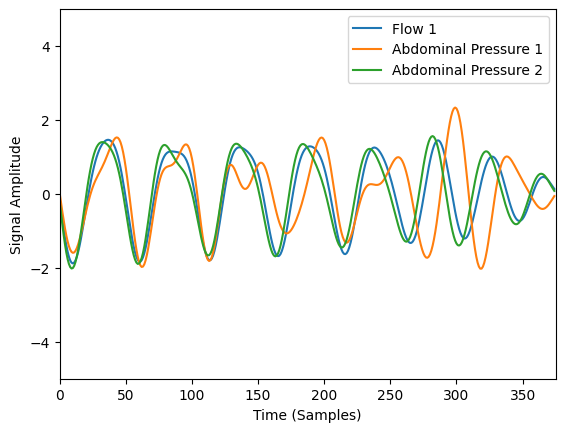

oh
----------------------------------------------------------------------------------------------------
/kaggle/input/isruc-processed/dataset/Events/oh/S1_p97_1_Stagen1_Event85_Session1.csv
(4, 1)


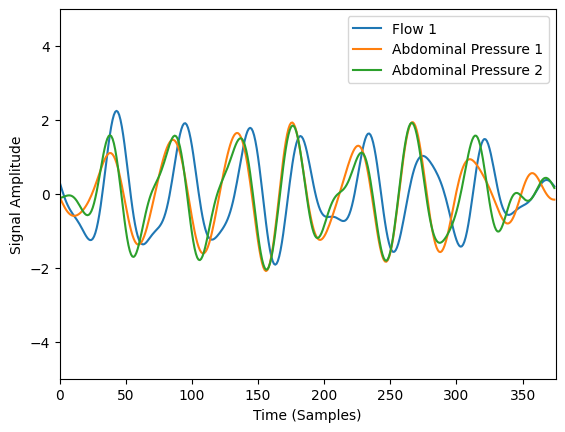

oh
----------------------------------------------------------------------------------------------------
/kaggle/input/isruc-processed/dataset/Events/oh/S1_p91_1_Stager_Event1_Session1.csv
(4, 1)


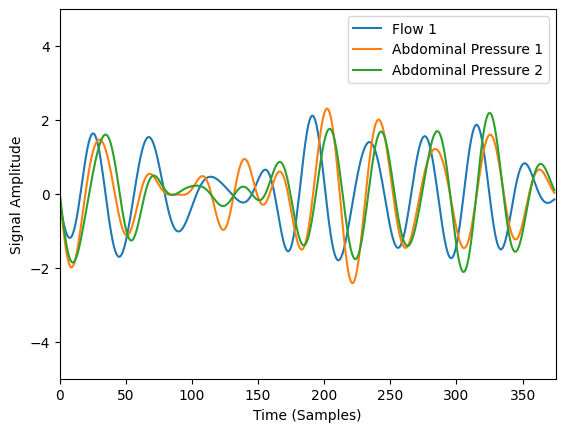

oh
----------------------------------------------------------------------------------------------------
/kaggle/input/isruc-processed/dataset/Events/mh/S1_p2_1_Stagen2_Event29_Session1.csv
(4, 1)


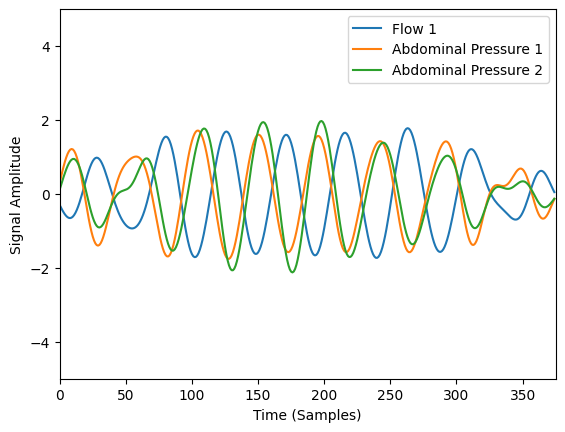

mh
----------------------------------------------------------------------------------------------------


In [10]:
root_dir = '/kaggle/input/isruc-processed/dataset'

included_classes = ['ca', 'oa', 'oh', 'mh', 'ch', 'no_event']

transform = [BandpassFilter(lowcut=0.2, highcut=0.5, fs=12.5), Normalization(method='z-score', axis=1)]

# Create an instance of the SleepStageDataset
event_classification_dataset = EventClassificationDataset(root_dir=root_dir, transform=transform, included_classes=included_classes)

# Wrap in a DataLoader for batch processing
event_classification_loader = DataLoader(event_classification_dataset, batch_size=1, shuffle=True)

# Iterate through the DataLoader
count = 3
for signals, labels in event_classification_loader:
    print(included_classes[np.argmax(labels)])
    print('-'*100)
    if count == 0:
        break
    count -= 1